# COMP532-202324 Assignment 2: Deep Reinforcement Learning

The assignment aims to design and implement a deep reinforcement learning agent for a video game from OpenAI Gym or Gymnasium

In [32]:
#@title Ignore Warning Message from Colab
import warnings

warnings.filterwarnings('ignore')

In [33]:
#@title Install and update all missing packages

#%%capture
# run package installation on bash
%%bash
# update apt-get
apt-get
# install swig
apt-get install swig
apt install xvfb
# install xvfb python-opengl ffmpeg
apt-get install -y python-opengl ffmpeg > /dev/null 2>&1
pip install gymnasium[Box2D]
pip install gym pyvirtualdisplay > /dev/null 2>&1
pip install pyglet

apt 2.4.12 (amd64)
Usage: apt-get [options] command
       apt-get [options] install|remove pkg1 [pkg2 ...]
       apt-get [options] source pkg1 [pkg2 ...]

apt-get is a command line interface for retrieval of packages
and information about them from authenticated sources and
for installation, upgrade and removal of packages together
with their dependencies.

Most used commands:
  update - Retrieve new lists of packages
  upgrade - Perform an upgrade
  install - Install new packages (pkg is libc6 not libc6.deb)
  reinstall - Reinstall packages (pkg is libc6 not libc6.deb)
  remove - Remove packages
  purge - Remove packages and config files
  autoremove - Remove automatically all unused packages
  dist-upgrade - Distribution upgrade, see apt-get(8)
  dselect-upgrade - Follow dselect selections
  build-dep - Configure build-dependencies for source packages
  satisfy - Satisfy dependency strings
  clean - Erase downloaded archive files
  autoclean - Erase old downloaded archive files
  c

In [96]:
# import gym package
import gym
from gym.wrappers.record_video import RecordVideo

# import plot packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for helping visualize the learning agents on google colab (record the videos as well)
from pyvirtualdisplay import Display
from IPython import display as ipydisplay
import glob
import os
import re
import io
import base64

# import torch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# others
import random
import numpy as np

In [97]:
# Set up a virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

### Visualizing the learning agents

In [104]:
#@title Declare the display video function

def display_video(path) -> None:
  video = io.open(path, 'r+b').read() # using io to open the video file
  # mostly html read video files with encoded as base64, so we encode the video file.
  file_encoded = base64.b64encode(video)

  # Use HTML element to display video file
  ipydisplay.display(ipydisplay.HTML(data='''<video alt="test" autoplay
          loop controls style="height: 400px;">
          <source src="data:video/mp4;base64,{0}" type="video/mp4" />
      </video>'''.format(file_encoded.decode('ascii'))))

In [105]:
#@title Show the learning agents from Lunar Lander environment

# Define wrapping the environment with "RecordVideo" Wrapper
env_wrapper = lambda env: RecordVideo(env, './video')

# Create the lunar lander environment
# Use the wrap_env function to enable for rendering the video,
# The enviroment parameter is "LunarLander-v2" render in "rgb_array" mode
env = env_wrapper(gym.make('LunarLander-v2', render_mode='rgb_array', new_step_api=True))

# Reset the environment and intialise the observation
observation = env.reset()

# Run an episode in the environment
while True:
    # Render the environment visually
    env.render()

    # Sampling a random action from action space
    action = env.action_space.sample()
    # Take a step in the environment using the selected action
    observation, reward, terminate, info = env.step(action)

    # Break the loop after the episode has ended.
    if terminate:
        break

# Close the environment after the epsiode has ended.
env.close()

In [106]:
#@title Display example learning agents video

mp4list = glob.glob('video/*.mp4') # find all .mp4 files

# Check, Are there any MP4 files existed?
if len(mp4list) > 0:
    mp4 = mp4list[0] # select the first one of the list
    display_video(mp4)
else:
    # If no MP4 files are found, print an error message
    print("Could not find video")

In [107]:
#@title Set up matplotlib for plotting
# Check if the current backend is for inline plotting
is_ipython = 'inline' in matplotlib.get_backend()

#  import the 'display' from IPython, if it is inline plotting
if is_ipython:
    from IPython import display

# Enable iteractive mode which allow to plot update dynamictically
plt.ion()

In [108]:
#@title Use cuda if running on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters

* `BATCH_SIZE`: The number of trainsitions sampled from the replay buffer.
* `LR`: the learning rate of the optimizer
* `GAMMA`: The discount factor and it should be a constant between 0 and 1 that ensures the sum of rewards converges.
* `EPS_START`: The starting value of epsilon.
* `EPS_END`: The final value of epsilon.
* `EPS_DECAY`: The rate of exponential decay of epsilonm higher mean a slower decay.
* `EPISODES_NUM`: The number of episodes of using in training.
* `MAX_STEP`: The maximum number of steps per episode determines the maximum numver of action agent can take in a single episode.

In [110]:
BATCH_SIZE = 64
LR = 0.001 # Learning Rate
GAMMA = 0.99 # Discount Factor
EPS_START = 1.0
EPS_END = 0.09
EPS_DECAY = 0.995
EPISODES_NUM = 1000
MAX_STEP = 200

In [111]:
# Create wrapper function which wraps the given environmet with RecordVideo
def env_learning_wrapper(env):
  # Define the function that save video for every 5 episodes after the episode 900 no.
  def record_video(episode_id):
    # No record if it is lower the boundary
    if episode_id < 899:
      return False
    # Return every 5 episodes
    return (episode_id - 899) % 5 == 0

  # Use the RecordVideo to record the agent's performance while learning process
  # The video files will be saved in the './learning_video' directory
  env = RecordVideo(env, './learning_vid', episode_trigger= record_video)

  # Return the wrapped environment
  return env

# Create a Lunar Lander environment and render with 'rgb_array' (It is useful to record the video according to return as NumPy array)
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Wrap the environment to allow recording the videos.
env = env_learning_wrapper(env)

In [112]:
# Create the DQN class, inheriting from the PyTorch nn.Module class
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()# Calling the superclass
        self.fc1 = nn.Linear(n_observations, 64) # Assign the first(input) layer and start with 64 output units
        self.fc2 = nn.Linear(64, 64) # Assign the second layer with 64/64 (i/o) units
        self.fc3 = nn.Linear(64, n_actions) # Assign the third layer with 64 input units and the number of actions (output dimension) as output units

    # Call with either one element to determine next action, or a batch
    def forward(self, x):
        # Assign first and second fully conntect following by the ReLU activation funciton
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # This layer return raw Q-values for each action, which can be either positive or negative
        x = self.fc3(x)
        return x # Return Q-values for each action


In [113]:
# Create ReplayMemory as a replay buffer to store the transition of agents
class ReplayMemory:
    # Initialize the replay buffer with specific capacity
    def __init__(self, cap):
        self.cap = cap  # Max number of experience that the memory can store
        self.memory = []  # Assign memory list to store experience
        self.position = 0  # Current position in memory for adding the next experience

    # Add a new experience tuple to the replay buffer
    def push(self, state, action, reward, next_state, done):
        # It the memory is not full, so add a new slot (check with capacity)
        if len(self.memory) < self.cap:
            self.memory.append(None)

        # Add the experience at the current position in the memory
        self.memory[self.position] = (state, action, reward, next_state, done)

        # Update the position for the circular
        self.position = (self.position + 1) % self.cap

    # Sample a batch of experience tuples from the memory
    def sample(self, batch_size):
        # Randomly select a batch of experience tuples
        batch = random.sample(self.memory, batch_size)
        # Unpack the experience into separate arrays for states, actions, rewards, next_states, and terminated
        states, actions, rewards, next_states, terminated = zip(*batch)

        # Convert the arrays to NumPy arrays
        return (
            np.array(states),
            np.array(actions),
            # Assign reward as float type, avoid inappropiate type to process.
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(terminated, dtype=np.uint8),
        )


In [114]:
#@title Assign the utilities of training DQN

n_actions = env.action_space.n  # Output dimensions
n_observations = env.observation_space.shape[0] # Input dimensions
dqn = DQN(n_observations, n_actions).to(device) # Create the DQN model by passing Input & Output Dimension

# Set up the optimizer with AdamW
optimizer = optim.AdamW(dqn.parameters(), lr=LR)

# Initialize the replay memory with a capacity of 10000
rep_memory = ReplayMemory(10000)

# Function to select an action based on the current state and epsilon for exploration-exploitation trade-off
def select_action(state, epsilon):
  # With probability epsilon, select a random action (exploration)
  if np.random.random() < epsilon:
    return env.action_space.sample()
  else:
    # Otherwise, select the action with the highest Q-value (exploitation)
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    q_values = dqn(state)
    _, action = q_values.max(1)
    return action.item()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [115]:
#@title Create training function

def train():
  # Initialize epsilon and reward list
  epsilon = EPS_START
  rewards_list = []

  # Loop through each episode
  for episode in range(EPISODES_NUM):
    # initialise the values; state, is_terminate, total_reward
    state = env.reset()
    is_terminate = False
    total_reward = 0

    # Loop through each step in each episode
    for step in range(MAX_STEP):
      # Select an action
      action = select_action(state, epsilon)

      # Perform the action and observe the next state, reward, and terminate loop(is_terminate) status
      next_state, reward, is_terminate, _ = env.step(action)
      total_reward += reward

      # Store the experience in the memory
      rep_memory.push(state, action, reward, next_state, is_terminate)
      state = next_state

      # Start train, if the memory has enough experience (comparing with batch sizes)
      if len(rep_memory.memory) > BATCH_SIZE:
        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, terminates = rep_memory.sample(BATCH_SIZE)

        # Convert the experiences to PyTorch tensors and move them to the appropriate device
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        terminates = torch.FloatTensor(terminates).to(device)

        # Calculate the current Q-values using the DQN model
        q_vals = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Calculate the next Q-values using the target model
        next_q_vals = dqn(next_states).max(1)[0]

        # Calculate the target Q-values using the Bellman equation
        target_q_values = rewards + (1 - terminates) * GAMMA * next_q_vals

        # Calculate the loss between the current Q-values and target Q-values
        loss = nn.functional.mse_loss(q_vals, target_q_values.detach())

        # Zero the gradients, perform backpropagation, and update the DQN's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # break the loop after finish the episode
      if is_terminate:
          break;

    # Add the total reward for the current episode to the rewards list
    rewards_list.append(total_reward)

    # Decay epsilon to decrease exploration over time
    epsilon = max(EPS_END, EPS_DECAY * epsilon)

    # Print the current episode, reward, and epsilon
    print(f"Episode {episode+1}, reward: {total_reward:.2f}, epsilon: {epsilon:.2f}")

  # Close the environment after training
  env.close()

  # Return the list of rewards for each episode
  return rewards_list

In [116]:
#@title Training the DQN model

rewards = train()

Episode 1, reward: -409.28, epsilon: 0.99
Episode 2, reward: -88.20, epsilon: 0.99
Episode 3, reward: -47.47, epsilon: 0.99
Episode 4, reward: -310.91, epsilon: 0.98
Episode 5, reward: -131.42, epsilon: 0.98
Episode 6, reward: -214.67, epsilon: 0.97
Episode 7, reward: -128.98, epsilon: 0.97
Episode 8, reward: -132.29, epsilon: 0.96
Episode 9, reward: -114.36, epsilon: 0.96
Episode 10, reward: -60.94, epsilon: 0.95
Episode 11, reward: -276.88, epsilon: 0.95
Episode 12, reward: -114.93, epsilon: 0.94
Episode 13, reward: -310.89, epsilon: 0.94
Episode 14, reward: -154.11, epsilon: 0.93
Episode 15, reward: -269.18, epsilon: 0.93
Episode 16, reward: -230.36, epsilon: 0.92
Episode 17, reward: -112.11, epsilon: 0.92
Episode 18, reward: -380.29, epsilon: 0.91
Episode 19, reward: -151.97, epsilon: 0.91
Episode 20, reward: -275.32, epsilon: 0.90
Episode 21, reward: -76.65, epsilon: 0.90
Episode 22, reward: -381.66, epsilon: 0.90
Episode 23, reward: -138.65, epsilon: 0.89
Episode 24, reward: -85.

# Evaluation the perfomance

After the training process, we would like to evalute our model to test the ability of agent for problem solving of agent's performance.

What we are going to do is to
1. Initialize the parameters
  * `state`: The state of enviroment
  * `is_terminate`: Represent the flag to terminat the loop as a boolean value = `FALSE`
  * `total_reward`: The number of total reward before aggregation in the loop.


In [117]:
def model_evaluation():
  # Initialise parameters
  state = env.reset() # To reset the environment state
  is_terminate = False # Represent value to terminate the loop
  total_reward = 0 # Initialize the total reward as 0

  # Continue evaluating the agent until finished the episode
  while not is_terminate:
    # Convert the current state to a PyTorch tensor, add a batch dimension, and move it to the device
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    # Obtain the Q-values for the current state from DQN
    q_vals = dqn(state)
    # Select the highest Q-value as an action [argmax(q_vals)]
    _, action = q_vals.max(1)
    # Execute the selected action in the environment
    next_state, reward, is_terminate, _ = env.step(action.item())

    # Commulative rewards
    total_reward += reward
    # Update the state to the next state
    state = next_state

  # Close the environment
  env.close()
  # Return the total reward for the evaluation episode
  return total_reward


TEST_EPISODE = 200 # Set the number of test episodes
test_rewards = [] # Initialise empty list for rewards in each test ep.

# Run the evaluation for the specified number of test episodes
for i in range(TEST_EPISODE):
    # Evaluate the agent and get the total reward for the current test episode
    test_reward = model_evaluation()
    # Add the total reward to the list
    test_rewards.append(test_reward)
    # Print out the current test episode number and reward
    print(f"Test episode {i+1}, reward: {test_reward:.2f}")

# Calculate and print the average reward over all test episodes
print(f"Average reward over {TEST_EPISODE} test episodes: {np.mean(test_rewards):.2f}")

Test episode 1, reward: -66.04
Test episode 2, reward: -196.49
Test episode 3, reward: -83.24
Test episode 4, reward: -138.02
Test episode 5, reward: 191.03
Test episode 6, reward: -100.25
Test episode 7, reward: -45.30
Test episode 8, reward: -134.81
Test episode 9, reward: -103.43
Test episode 10, reward: 252.86
Test episode 11, reward: 232.58
Test episode 12, reward: -101.59
Test episode 13, reward: 98.51
Test episode 14, reward: 249.22
Test episode 15, reward: -100.36
Test episode 16, reward: 287.02
Test episode 17, reward: -165.74
Test episode 18, reward: -56.51
Test episode 19, reward: -280.72
Test episode 20, reward: 263.04
Test episode 21, reward: 213.34
Test episode 22, reward: -149.77
Test episode 23, reward: 107.89
Test episode 24, reward: -136.48
Test episode 25, reward: 240.23
Test episode 26, reward: 146.26
Test episode 27, reward: 248.56
Test episode 28, reward: -32.03
Test episode 29, reward: -129.92
Test episode 30, reward: 275.72
Test episode 31, reward: -12.03
Test e

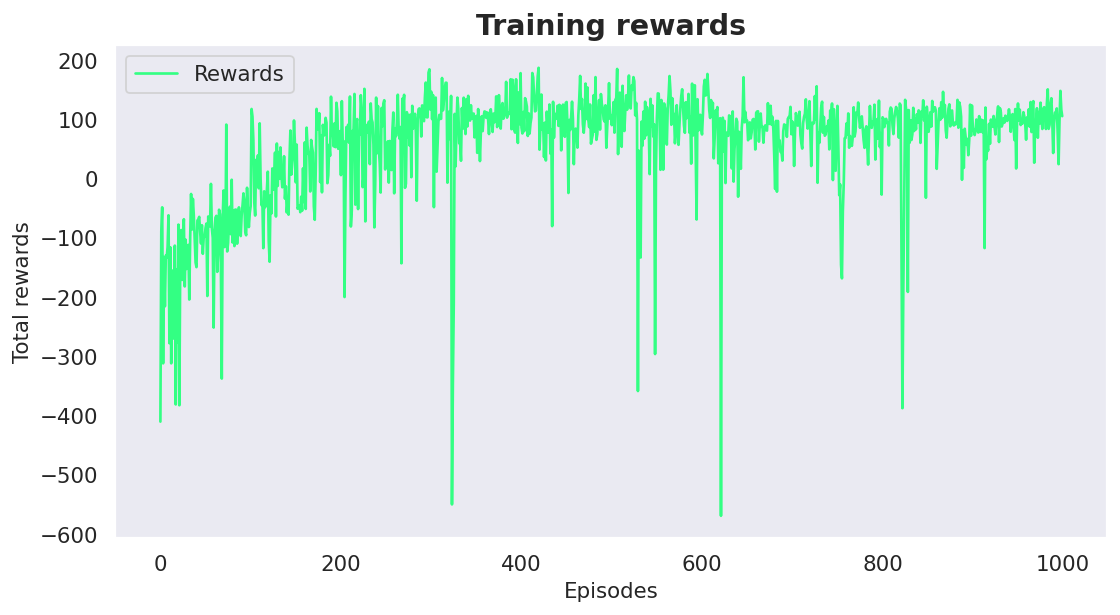

In [127]:
#@title Using seaborn library to plot graph

sns.set(style="dark")  # Set seaborn style

plt.figure(figsize=(10, 5), dpi=128)  # Set the figure size

plt.plot(rewards, color="#33FF83", linewidth=1.5, label="Rewards")  # Customize the line color and width
plt.xlabel('Episodes', fontsize=12)  # Customize the x-axis label and font size
plt.ylabel('Total rewards', fontsize=12)  # Customize the y-axis label and font size
plt.title('Training rewards', fontsize=16, fontweight='bold')  # Customize the title, font size, and weight
plt.legend(fontsize=12)  # Display the legend
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display graph
plt.show()


In [121]:
#@title Store the sucessful agents videos

folder = "learning_vid"  # Assign the folder containing the videos
compiling_pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")  # Create a regular expression pattern to match video filenames

successful_episodes = []  # Initialize a variable to store the episode numbers for which the agent gets to the finish line

# Obtain the overall reward by the sum of train and test rewards
overall_rewards = rewards + test_rewards

# Looping to store the video
for filename in os.listdir(folder):
  print(filename)
  match = compiling_pattern.match(filename)  # Check if the filename matches the pattern or not
  if match:
    nn = int(match.group(1))  # Extract the episode number 'nn' from the matched
    print("heel")
    if nn< 200:   # check if epsisode number is within valid range
      if overall_rewards[nn] > -100:  # check if the extracted episode number has a successful run or not
        successful_episodes.append(nn)  # append the episode number to the successful episode list

# sort the list of successful episodes so that the latest episode for which reward is >200 is at the last element of list
successful_episodes = sorted(successful_episodes)

rl-video-episode-49.mp4
heel
rl-video-episode-49.meta.json


In [125]:
video_folder = "learning_vid"  # Define the folder containing the videos
video_pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")  # Create a regular expression pattern to match video filenames

successful_episodes = []  # Initialize a variable to store the episode numbers for which the agent gets to the finish line

# combine training and test rewards
overall_rewards = rewards + test_rewards

# Iterate through the filenames in the video_folder
for filename in os.listdir(video_folder):
    match = video_pattern.match(filename)  # Check if the filename matches the video_pattern
    if match:  # If the pattern matches
        nn = int(match.group(1))  # Extract the episode number 'nn' from the matched filename
        if nn<600:   # check if epsisode number is within valid range
          if overall_rewards[nn] > -200:  # check if the extracted episode number has a successful run or not
            successful_episodes.append(nn)  # append the episode number to the successful episode list

# sort the list of successful episodes so that the latest episode for which reward is >200 is at the last element of list
successful_episodes = sorted(successful_episodes)

In [126]:
successful_episodes

[49]

In [123]:
#@title Display the result from successful episodes

video_order = [successful_episodes[-1]] # use the latest episode from the successful episodes list

# Iterate through the video_order list
for order in video_order:
    # Get path from joining between directory and file names
    video_path = os.path.join("learning_vid", f"rl-video-episode-{order}.mp4")
    # Check if the video file exists
    if os.path.exists(video_path):
        # Display the video throught display_video function
        print("Learning agent after training and testing, episode {} :".format(successful_episodes[-1]+1))
        display_video(video_path)
    else:
        # If the video file is not found, print a message
        print(f"Not found: dqn-ep-{order}.mp4")


Learning agent after training and testing, episode 50 :
